# Time Series Forecasting Model Evaluation

### Common Imports

In [16]:
from sklearn.model_selection import train_test_split

from helpers import *
from abstract import ForecastingMethod
import numpy as np

### Shared Parameters

In [17]:
TRAIN_TEST_RATIO = 8 / 10
START_DATE = date(2020, 1, 1)

### Training & Test Data Preparation

In [18]:
# Preprocess the data: apply normalization and scaling like the paper does
new_filepath, min_value, max_value, initial_value = (
    ForecastingMethod.preprocess_data(
        filepath="../data/paper-data.csv",
        difference=False,
        scale_to_range=True,
        training_data_cutoff=TRAIN_TEST_RATIO,
    )
)

# Load the data
X, y = ForecastingMethod.load_data(filepath=new_filepath)
train_test_split_index = int(len(X) * TRAIN_TEST_RATIO)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=(1 - TRAIN_TEST_RATIO), shuffle=False
)

# Linear Regression

In [19]:
from linear_regression import LinearRegression

### Training - Model Creation & Weight Finding

In [20]:
models = [
    (
        "Linear Regression",
        LinearRegression(
            regularization=None, fit_intercept=False, cv_folds=None
        ),
    ),
    (
        "Linear Regression with Y-Intercept",
        LinearRegression(
            regularization=None, fit_intercept=True, cv_folds=None
        ),
    ),
    (
        "L1 Regularized Linear Regression",
        LinearRegression(
            regularization="l1",
            fit_intercept=True,
            cv_folds=5,
            alphas=[0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1, 5, 10, 100],
        ),
    ),
    (
        "L2 Regularized Linear Regression",
        LinearRegression(
            regularization="l2",
            fit_intercept=True,
            cv_folds=5,
            alphas=[
                0.0001,
                0.001,
                0.01,
                0.1,
                0.3,
                0.5,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                10,
                100,
            ],
        ),
    ),
]

for name, model in models:
    model.train(X_train, y_train)

### Prediction - Timeseries Forecasting & Evaluation

In [21]:
for name, model in models:
    print("#" * 50)
    print(name)
    print("#" * 50)
    print(f"Training Loss (MSE): {model.score(X_train, y_train)}")
    print(f"Testing Loss (MSE): {model.score(X_test, y_test)}")
    if "alpha" in model.model.get_params():
        print(f"Best Alpha: {model.model.get_params()["alpha"]}")

##################################################
Linear Regression
##################################################
Training Loss (MSE): 0.0032069768114603853
Testing Loss (MSE): 0.016574911264773406
##################################################
Linear Regression with Y-Intercept
##################################################
Training Loss (MSE): 0.0029244610958291165
Testing Loss (MSE): 0.012877015472535202
##################################################
L1 Regularized Linear Regression
##################################################
Training Loss (MSE): 0.007743328604930426
Testing Loss (MSE): 0.010563714205386156
Best Alpha: 0.01
##################################################
L2 Regularized Linear Regression
##################################################
Training Loss (MSE): 0.006813746040059361
Testing Loss (MSE): 0.01075051144461456
Best Alpha: 2


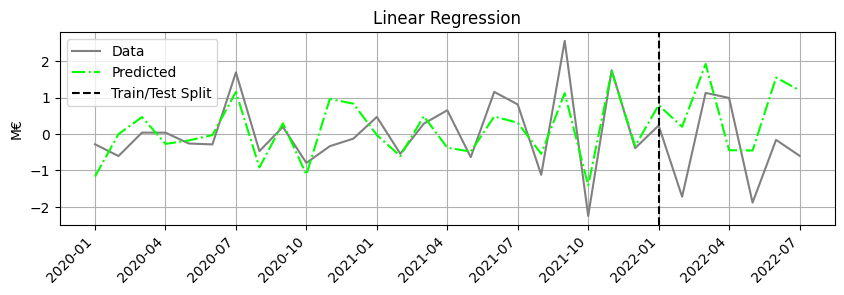

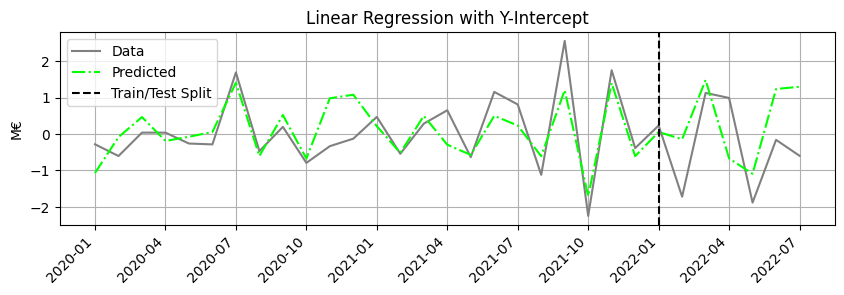

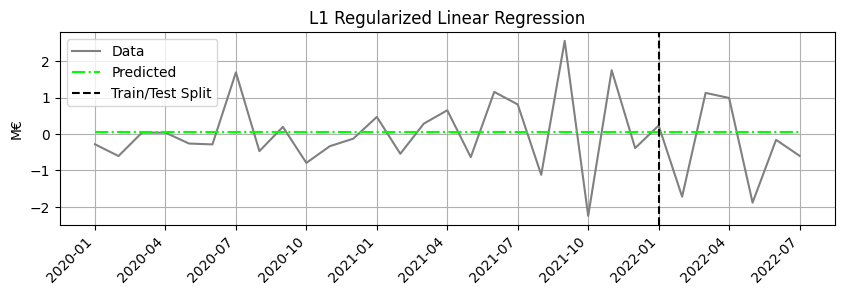

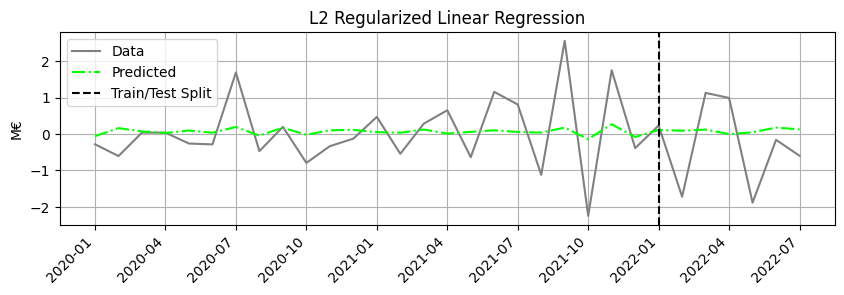

In [22]:
for name, model in models:
    # Post process X
    X_pred_scaled = ForecastingMethod.post_process_data(
        model.predict(X),
        min_value,
        max_value,
        initial_value,
        scale_to_range=True,
    )
    # Post process y
    y_scaled = ForecastingMethod.post_process_data(
        y, min_value, max_value, initial_value, scale_to_range=True
    )

    plot_sales_growth(
        START_DATE,
        y_scaled,
        X_pred_scaled,
        pred_linestyle="-.",
        pred_color="lime",
        title=name,
        train_test_split=train_test_split_index,
    )

# PQC

In [23]:
from pqc import PQC

### Training - Model Creation & Weight Finding

In [24]:
N_WIRES = 12
N_LAYERS = 2

# Create L-BFGS-B model
pqc_model_lbfgsb = PQC(
    n_wires=N_WIRES, n_layers=N_LAYERS, optimizer="L-BFGS-B"
)
# Create the COBYLA model
pqc_model_cobyla = PQC(n_wires=N_WIRES, n_layers=N_LAYERS, optimizer="COBYLA")

# load weights - since training takes 30+ minutes
pqc_model_lbfgsb.load_weights("../weights/pqc_lbfgsb.npy")
pqc_model_cobyla.load_weights("../weights/pqc_cobyla.npy")

True

### Prediction - Timeseries Forecasting & Evaluation

In [25]:
# Predict the dataset as whole
predictions_L = pqc_model_lbfgsb.predict(X)
predictions_C = pqc_model_cobyla.predict(X)

# Compute the training loss with processed data
train_mse_L = np.mean((predictions_L[:train_test_split_index] - y_train) ** 2)
train_mse_C = np.mean((predictions_C[:train_test_split_index] - y_train) ** 2)

# Compute testing loss
test_mse_L = np.mean((predictions_L[train_test_split_index:] - y_test) ** 2)
test_mse_C = np.mean((predictions_C[train_test_split_index:] - y_test) ** 2)

print("#" * 50)
print("PQC with L-BFGS-B Optimizer")
print("#" * 50)
print(f"Training Loss (MSE): {train_mse_L}")
print(f"Test Loss (MSE): {test_mse_L}")
print("#" * 50)
print("PQC with COBYLA Optimizer")
print("#" * 50)
print(f"Training Loss (MSE): {train_mse_C}")
print(f"Test Loss (MSE): {test_mse_C}")

##################################################
PQC with L-BFGS-B Optimizer
##################################################
Training Loss (MSE): 0.004288775586416768
Test Loss (MSE): 0.011969983879399985
##################################################
PQC with COBYLA Optimizer
##################################################
Training Loss (MSE): 0.005599549793777868
Test Loss (MSE): 0.009690624175123608


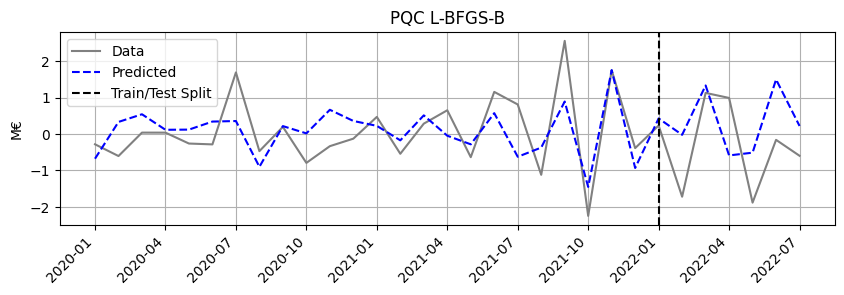

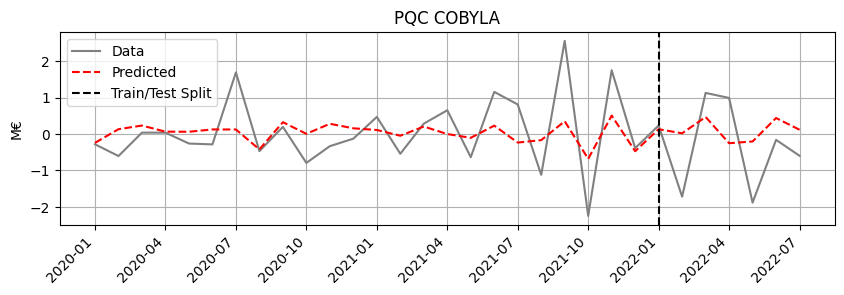

In [26]:
# Post process the predictions
predictions_L_scaled = ForecastingMethod.post_process_data(
    predictions_L, min_value, max_value, initial_value, scale_to_range=True
)
predictions_C_scaled = ForecastingMethod.post_process_data(
    predictions_C, min_value, max_value, initial_value, scale_to_range=True
)
# Post process y
y_scaled = ForecastingMethod.post_process_data(
    y, min_value, max_value, initial_value, scale_to_range=True
)

# Plot the results
plot_sales_growth(
    START_DATE,
    y_scaled,
    predictions_L_scaled,
    pred_linestyle="--",
    pred_color="blue",
    title="PQC L-BFGS-B",
    train_test_split=train_test_split_index,
)
plot_sales_growth(
    START_DATE,
    y_scaled,
    predictions_C_scaled,
    pred_linestyle="--",
    pred_color="red",
    title="PQC COBYLA",
    train_test_split=train_test_split_index,
)

# Neural Network

In [27]:
from neural_network import NeuralNetwork

### Training - Model Creation & Weight Finding

In [28]:
nn = NeuralNetwork()
nn.train(X_train, y_train)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0153
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0172
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0121
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0142
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0121
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0145
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0085
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0092
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0100
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0104
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0076
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0072
Epoch 14/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0065
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0086
Epoch 16/200
3/3 ━━

### Prediction - Timeseries Forecasting & Evaluation

In [29]:
predictions = nn.predict(X)

train_mse = np.mean((predictions[:train_test_split_index] - y_train) ** 2)
test_mse = np.mean((predictions[train_test_split_index:] - y_test) ** 2)

print(f"Training Loss (MSE): {train_mse}")
print(f"Testing Loss (MSE): {test_mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Training Loss (MSE): 0.015339926350353202
Testing Loss (MSE): 0.01476100939082101


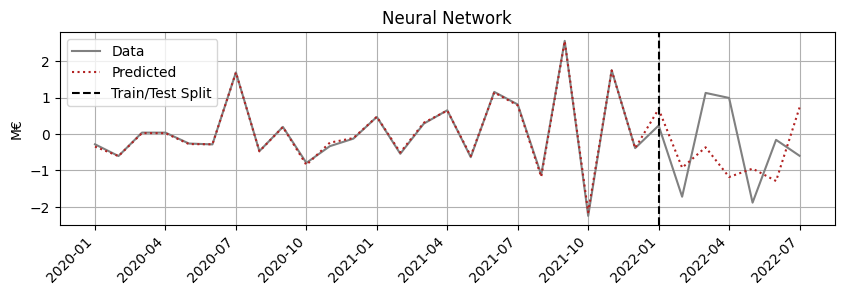

In [30]:
# Post process X
X_pred_scaled = ForecastingMethod.post_process_data(
    predictions, min_value, max_value, initial_value, scale_to_range=True
)
# Post process y
y_scaled = ForecastingMethod.post_process_data(
    y, min_value, max_value, initial_value, scale_to_range=True
)

plot_sales_growth(
    START_DATE,
    y_scaled,
    X_pred_scaled,
    pred_linestyle=":",
    pred_color="firebrick",
    title="Neural Network",
    train_test_split=train_test_split_index,
)